# 最简单的深度学习

这是一条插播的内容：主要是作为 Functor 语法的一个实际应用，然后借此顺便简单介绍一下深度学习的基本概念。

建议：在看这部分内容之前做一下之前的小作业效果更佳。`2_4_homework.ipynb`

深度学习本质上由三个部分组成：

- 复合函数 $f(X; \Theta) = f_1 \circ \cdots \circ f_n$ ，其中每个子函数 $f_i$ 的结构都相对简单. 函数 $f$ 的输入和输出一般都是向量值函数。每个子函数都可能有一些权重和参数，这些参数的整体称为网络的参数 $\Theta$
- 迭代优化算法：一般是基于梯度的一阶算法，这里面最简单的是梯度下降法。当然在数据很大的情况下，就延伸出了一些随机的优化方法。
- 梯度的计算：现代深度学习框架都基于自动微分来实现，从而避免过多的手动计算导数的环节

所谓训练一个神经网络，实际上就是求解优化问题

$$
\min_\Theta L(f, D)
$$

其中 $L$ 为损失函数，$D$ 为外部数据。根据 $L$, $f$, 与 $D$ 的不同组合，就构成了不同的深度学习方法。例如，根据是否需要外部数据 $D$ 可以分为：

- 有监督学习：一般情况下 $D$ 由两部分组成 $D = {X, Y}$ 分别为已知的输入和输出，并且损失函数通常具有形式 $L(f(X), Y)$
- 无监督学习：不存在训练数据集 $D$，单纯从 $f(X)$ 本身的性质出发来进行优化

In [1]:
# 这些包如果没有的话，可以通过进入到 Pkg 模式来安装
using Random
using OffsetArrays # 构造多项式
using Zygote # 自动微分
using Plots # 绘图
using ProgressMeter # 打印循环状态

## 曲线拟合

最简单的一类可以用深度学习方法来实现的问题是曲线的拟合问题。简单起见，我们这里使用合成一维数据

In [2]:
function make_dataset(n; ratio=0.8)
    X = 1.5 .* randn(n) .+ 3
    Y = 2X.^2 + 0.2X.^2 .+ 0.2randn(n).*X # 随手造的
    indices = randperm(n)
    num_obs = ceil(Int, n*ratio)
    train_data = (X[indices[1:num_obs]], Y[indices[1:num_obs]])
    test_data = (X[indices[num_obs+1:end]], Y[indices[num_obs+1:end]])
    return train_data, test_data
end

make_dataset (generic function with 1 method)

一般来说关于网络训练数据集分为三类：

- 训练集 (training set)： 知道真实结果(groundtruth)，用来计算 loss 并更新权重
- 验证集 (validation set)： 知道真实结果，通常是由训练集中按照一定分布采样出来的结果。仅仅用于计算一些指标来验证模型的实际效果和泛化能力。
- 测试集 (testing set)：不一定知道真实结果，也不一定和训练集具有相同的概率分布。

对于我们随手造的这个数据来说，我们只有训练集和验证集（或者叫测试集也可以）。


In [3]:
(train_X, train_Y), (test_X, test_Y) = make_dataset(2000);

因为是一维数据，所以我们可以排个序之后直接绘图来观察

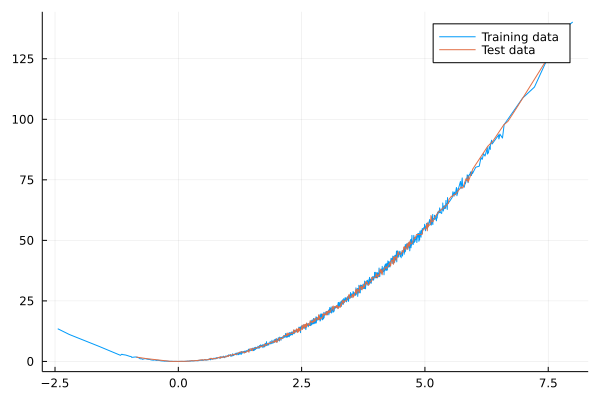

In [4]:
indices = sortperm(train_X)
p = plot(train_X[indices], train_Y[indices], label="Training data")

indices = sortperm(test_X)
plot!(p, test_X[indices], test_Y[indices], label="Test data") # 使用 plot! 绘制到图 p 上

## 多项式拟合

假设我们使用n阶多项式 $f(x; w) = \sum_{i=0} w_ix^i$进行逼近的话：

In [5]:
# Generator: (w[i]*x^i for i in eachindex(w))
# List comprehension: [w[i]*x^i for i in eachindex(w)]
# https://docs.julialang.org/en/v1/manual/arrays/#man-comprehensions
# https://docs.julialang.org/en/v1/manual/arrays/#Generator-Expressions
f_poly(x, w) = sum((w[i]*x^i for i in eachindex(w)))

n = 3 # n阶多项式
# Julia 指标从1开始，所以利用 OffsetArray 将指标移位到从0开始
w = OffsetVector(rand(n+1), -1)
# 如果是 w = rand(n+1) 的话，那么结果应该是 ([1, 2, 3, 4, 5],)
@show collect.(axes(w)) # 这里用 collect 只是为了更好地显示结果

f_poly(0, w)

collect.(axes(w)) = ([0, 1, 2, 3],)


0.508676288217107

显然，如果不调整参数 $w$ 的话拟合效果肯定是很差的

In [6]:
function plot_poly(f, X, Y)    
    Ŷ = f.(X)
    indices = sortperm(X)
    p = plot(X[indices], Y[indices], label="Groundtruth")
    plot!(p, X[indices], Ŷ[indices], label="Estimation")
end

plot_poly (generic function with 1 method)

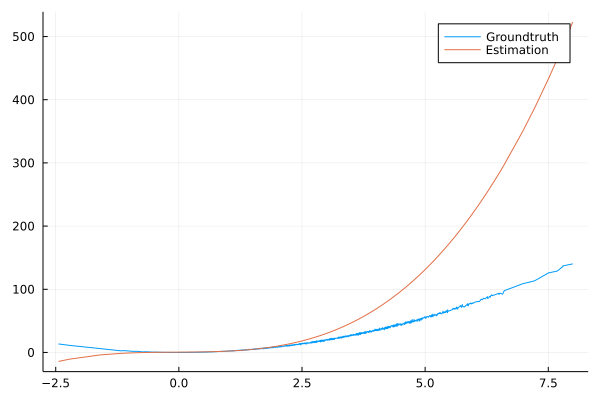

In [7]:
plot_poly(x->f_poly(x, w), train_X, train_Y)

所谓训练，就是通过迭代方法来求解最优的权重。最简单的迭代方法就是梯度下降法

In [8]:
# find the best w on dataset {X, Y}
function fit_poly(w, X, Y; num_iters=100, η=1e-3)
    # 以绝对值的平方和作为 loss
    l(w) = sum(abs2, map(x->f_poly(x, w), X) - Y)/length(X)
    @showprogress for i in 1:num_iters
        # gradient 函数支持多个输入参数，因为我们的输入只有一个，所以返回的是一个长度为1的Tuple
        ∂l∂w = gradient(l, w)[1]
        # 利用梯度更新权重
        @. w = w - ∂l∂w * η
        if i % 10 == 0
            @info "\nIteration $i" weight=w loss=l(w)
        end
    end
    return w
end

fit_poly (generic function with 1 method)

In [9]:
# 可以试试看其他的步长和阶数来体会一下所谓的调参数 :)
n = 2
w = OffsetVector(rand(n+1), -1)
w = fit_poly(w, train_X, train_Y; η=1e-5)

Progress:   9%|███▊                                     |  ETA: 0:01:10┌ Info: 
│ Iteration 10
│   weight = [0.71458682732095, 0.33964993872798016, 0.32223208545285775]
│   loss = 683.6391182316767
└ @ Main In[8]:11
Progress:  19%|███████▊                                 |  ETA: 0:00:41┌ Info: 
│ Iteration 20
│   weight = [0.7183879924322147, 0.3559123050539793, 0.3978390357628241]
│   loss = 623.8128144575089
└ @ Main In[8]:11
Progress:  29%|███████████▉                             |  ETA: 0:00:29┌ Info: 
│ Iteration 30
│   weight = [0.7220121221442473, 0.3714349285219818, 0.47005482414887556]
│   loss = 569.2365520109637
└ @ Main In[8]:11
Progress:  39%|████████████████                         |  ETA: 0:00:22┌ Info: 
│ Iteration 40
│   weight = [0.7254671642978644, 0.3862510151344813, 0.5390316630854416]
│   loss = 519.4496094352744
└ @ Main In[8]:11
Progress:  49%|████████████████████▏                    |  ETA: 0:00:17┌ Info: 
│ Iteration 50
│   weight = [0.7287607099928001, 0.4003

3-element OffsetArray(::Vector{Float64}, 0:2) with eltype Float64 with indices 0:2:
 0.7430486665413143
 0.4619901809654102
 0.8925753181428417

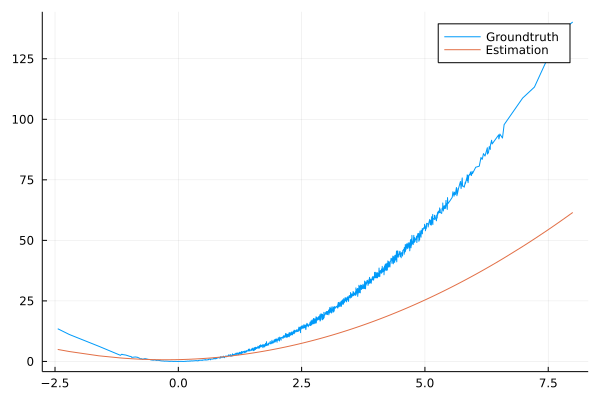

In [10]:
plot_poly(x->f_poly(x, w), train_X, train_Y)

## 基于 Functor 的模型设计

这上面的玩具代码就包含了一个完整的模型训练过程，这里面一个比较难处理的问题是，函数 f 的定义以及函数 f 的权重是分开处理的，这对于将函数模式化成一个网络层会带来一些不方便。Functor 的概念可以很好地避免这个问题。让我们将上面的代码重新写一遍：

In [11]:
struct Polynominal{AT<:AbstractVector}
    w::AT
end
Polynominal(n::Int) = Polynominal(OffsetVector(rand(n+1), -1))
(f::Polynominal)(x) = sum((f.w[i]*x^i for i in eachindex(f.w)))

function fit!(f::Polynominal, X, Y; num_iters=100, η=1e-3)
    l(f) = sum(abs2, f.(X) - Y)/length(X)
    @showprogress for i in 1:num_iters
        # 利用 gradient 拿到的梯度的结构会稍有不同：因为结构体 f 可能含有其他的数据
        ∂l∂w = gradient(l, f)[1].w
        # 利用梯度更新权重
        @. f.w = f.w - ∂l∂w * η
        if i % 10 == 0
            @info "\nIteration $i" weight=f.w loss=l(f)
        end
    end
    return f
end

fit! (generic function with 1 method)

通过将 `f` 的权重与`f` 本身绑定，是不是结构上就清晰多了

Progress:   9%|███▊                                     |  ETA: 0:00:44┌ Info: 
│ Iteration 10
│   weight = [0.3964444653161339, 0.8697133279229402, 0.5268864424942102]
│   loss = 470.23412552463736
└ @ Main In[11]:15
Progress:  19%|███████▊                                 |  ETA: 0:00:31┌ Info: 
│ Iteration 20
│   weight = [0.39954608083945636, 0.8830921937594493, 0.5895282809888358]
│   loss = 429.19506120436796
└ @ Main In[11]:15
Progress:  29%|███████████▉                             |  ETA: 0:00:24┌ Info: 
│ Iteration 30
│   weight = [0.40250108414439967, 0.8958584056697735, 0.6493614605831695]
│   loss = 391.7573195755973
└ @ Main In[11]:15
Progress:  39%|████████████████                         |  ETA: 0:00:20┌ Info: 
│ Iteration 40
│   weight = [0.4053160578478361, 0.9080394657726342, 0.7065120478340131]
│   loss = 357.60486379146414
└ @ Main In[11]:15
Progress:  49%|████████████████████▏                    |  ETA: 0:00:17┌ Info: 
│ Iteration 50
│   weight = [0.4079972891038676

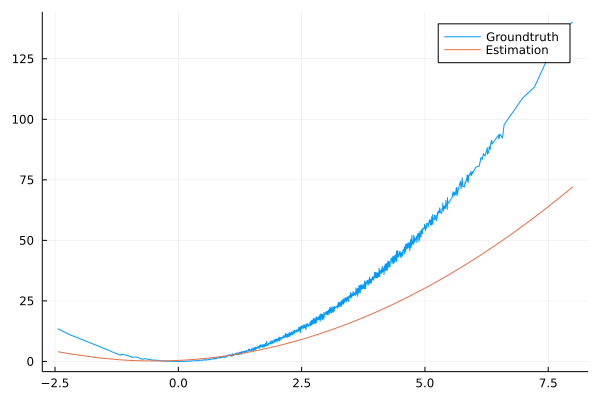

In [12]:
f = Polynominal(2)
fit!(f, train_X, train_Y; η=1e-5)
plot_poly(f, train_X, train_Y)

## 神经网络
下面我们构造神经网络（即多个简单函数的复合函数）来拟合它

In [13]:
abstract type Layer end
struct Linear{AT<:AbstractMatrix} <: Layer
    W::AT
    b::AT
end
Linear((from, to)::Pair{Int, Int}) = Linear(randn(to, from), zeros(to, 1))
(f::Linear)(x) = f.W*x .+ f.b

struct ReLU <: Layer end
(f::ReLU)(x) = max.(x, 0.0)

struct Sequential{AT<:AbstractVector{Layer}} <: Layer
    layers::AT
end
function (f::Sequential)(x)
    y = f.layers[1](x)
    for i in 2:length(f.layers)
        y = f.layers[i](y)
    end
    return y
end

In [14]:
model = Sequential([
        Linear(1=>10),
        ReLU(),
        Linear(10=>10),
        ReLU(),
        Linear(10=>1)
])

# 因为希望 Linear 可以适用于任何尺寸，所以这里拿到的其实是一个 1x1 的矩阵
model(train_X[1])

1×1 Matrix{Float64}:
 -3.4536720502805385

In [15]:
l(f) = sum(abs2, map(x->f(x)[1], train_X) - train_Y)
l(model)

2.422698495835144e6

再来查看一下梯度，这里内容就显得比较多了，因为关于每一个线性层都有对应的梯度，并且每一层可能有多个权重 (W, b). 简单打开来看一下数值的话就可以发现 `∇[i].layers[j]` 表示了`l`的第i个输入的第j层梯度。因为这里 `l` 只有一个输入参数 `model` 所以只需要 `∇[1]` 就可以了。例如，`∇[i].layers[1].W` 就表示 loss 关于第一层 W 的梯度。

In [16]:
∇ = gradient(l, model)
# 关于第一层W的梯度，以及关于第二层的梯度
# 如果不存在梯度（比如说没有权重），则这一层的结果为 nothing
∇[1].layers[1].W, ∇[1].layers[2]

([-34976.122991303404; 966.8061402955865; … ; -1834.4616242836473; -1.0660167170718238e6], nothing)

让我们再写一遍刚才的梯度下降法

In [17]:
function fit!(f::Sequential, X, Y; num_iters=100, η=1e-3)
    l(f) = sum(abs2, map(x->f(x)[1], train_X) - train_Y)/length(X)
    update!(w, ∂w) = @. w = w - ∂w*η
    @showprogress for i in 1:num_iters
        # 利用 gradient 拿到的梯度的结构会稍有不同：因为结构体 f 可能含有其他的数据
        ∇ = gradient(l, f)[1].layers
        for i in 1:length(f.layers)
            # Julia 里面逻辑运算是短路运算，即如果前面的逻辑判断已经能确定最终的结果了，那么就不会再执行
            # 后面的语句。在 Julia 里面经常用来做类似于下面这种逻辑跳转
            isnothing(∇[i]) && continue # 跳过 ReLU 层，因为不存在权重
            update!(f.layers[i].W, ∇[i].W)
            update!(f.layers[i].b, ∇[i].b)
        end
        # 利用梯度更新权重
        if i % 10 == 0
            @info "\nIteration $i" loss=l(f)
        end
    end
    return f
end

fit! (generic function with 2 methods)

In [18]:
# 构造一个 7 层的网络看看能不能暴力出奇迹
model = Sequential([
    Linear(1=>5),
    ReLU(),
    Linear(5=>10),
    ReLU(),
    Linear(10=>5),
    ReLU(),
    Linear(5=>1)
])
fit!(model, train_X, train_Y; num_iters=400, η=1e-4)

Progress:   2%|▉                                        |  ETA: 0:01:10┌ Info: 
│ Iteration 10
│   loss = 316.2011936632261
└ @ Main In[17]:16
Progress:   5%|██                                       |  ETA: 0:01:01┌ Info: 
│ Iteration 20
│   loss = 96.52198121427132
└ @ Main In[17]:16
Progress:   7%|███                                      |  ETA: 0:00:56┌ Info: 
│ Iteration 30
│   loss = 93.66854878590897
└ @ Main In[17]:16
Progress:  10%|████                                     |  ETA: 0:00:53┌ Info: 
│ Iteration 40
│   loss = 91.47225293296886
└ @ Main In[17]:16
Progress:  12%|█████                                    |  ETA: 0:00:50┌ Info: 
│ Iteration 50
│   loss = 89.31121006873057
└ @ Main In[17]:16
Progress:  15%|██████                                   |  ETA: 0:00:48┌ Info: 
│ Iteration 60
│   loss = 87.18167040827447
└ @ Main In[17]:16
Progress:  17%|███████▏                                 |  ETA: 0:00:46┌ Info: 
│ Iteration 70
│   loss = 85.08075689562203
└ @ Main In[17]:16

Sequential{Vector{Layer}}(Layer[Linear{Matrix{Float64}}([0.9975989500309828; -2.4967500088755465; … ; 0.24960527768391372; 0.8595578919157099], [-0.8330333112318082; -0.011666689175594238; … ; -0.1848447343287451; -0.49724239732027553]), ReLU(), Linear{Matrix{Float64}}([-1.5347600765789542 -1.4316238929109188 … -1.3521198319584544 -0.029138667364707504; -0.9550421529034097 0.8639604236258708 … -1.498009691213183 -0.6394996612752933; … ; 0.07488632167718326 0.5925249650633687 … 0.16760069707124936 -1.2942579443580033; -0.19547298673626926 0.7936472663898427 … 0.40453179954220203 0.9352489258285694], [0.0; -0.007837201922341287; … ; 0.003400819547142013; -0.0906277722692957]), ReLU(), Linear{Matrix{Float64}}([1.150896596606257 0.25913950684887843 … -1.1208555401367635 2.264235632650852; 1.1524358358218574 0.36708422700437005 … 0.23541593611961698 -1.6573058468903423; … ; -0.051472614875846194 -0.24880788012855293 … -0.26461515345175574 -1.5450759565871661; 2.2686134940963902 -0.207838265

In [19]:
function plot_model(f, X, Y)
    Ŷ = map(x->f(x)[1], X)
    indices = sortperm(X)
    p = plot(X[indices], Y[indices], label="Groundtruth")
    plot!(p, X[indices], Ŷ[indices], label="Estimation")
end

plot_model (generic function with 1 method)

效果似乎也还不错，但如果尝试一下其他的组合的话你会发现这个参数调试起来变得更难了...

这种将多个简单函数串在一起构成复合函数的模式就是现在深度学习的一个基本模式，只不过会使用一些更有效果的网络层、网络结构、以及优化器。

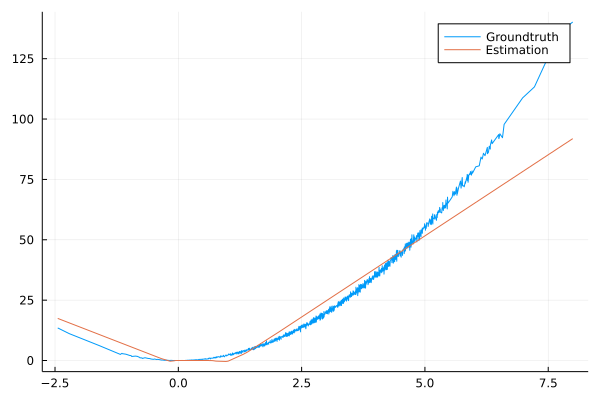

In [20]:
plot_model(model, train_X, train_Y)

## 小结

* 简单介绍了一下深度学习的一个基本模式：
  - 网络是一个复合函数，训练网络就是优化这个复合函数的权重
  - 使用自动微分来计算梯度
  - 之所以需要计算梯度，是因为我们的优化算法是基于梯度的迭代算法（梯度下降法）
* 还介绍了 Functor 模式在实际代码中的使用
* 以及一些所谓数据科学的代码

如果对于 Julia 下深度学习感兴趣，可以了解以下两个工具箱：

- Zygote: 提供了一个方便好用的自动微分
- Flux: 基于 Zygote 的深度学习框架（虽然相比于 Pytorch 或者 Tensorflow 来说还过于简陋）